In [8]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']

In [10]:
import os

In [35]:
files = glob(f'../data/interim/VisionBehaviorEncoding/*.csv.gz')
files.sort(key=os.path.getmtime)
files = files[-3:]
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

In [36]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [37]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_3744159/3200536758.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


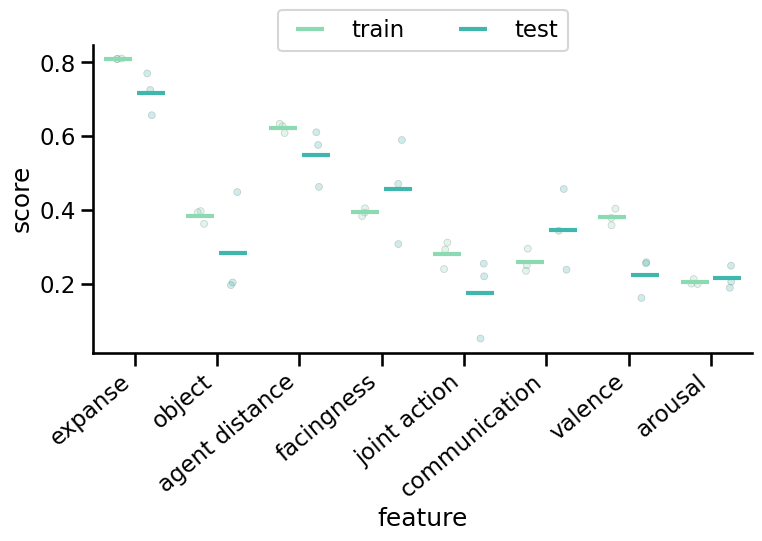

In [38]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)